<a href="https://colab.research.google.com/github/Teddyy27/Clustering/blob/main/cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install ucimlrepo

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from ucimlrepo import fetch_ucirepo


📊 2. Load and Preprocess Dataset

In [ ]:
# from ucimlrepo import fetch_ucirepo

# # fetch dataset
# air_quality = fetch_ucirepo(id=360)

# # data (as pandas dataframes)
# X = air_quality.data.features
# y = air_quality.data.targets

# # metadata
# print(air_quality.metadata)

# # variable information
# print(air_quality.variables)


In [4]:
data = fetch_ucirepo(id=360)
df = pd.concat([data.data.features, data.data.targets], axis=1)

# Check the actual columns after combining
print(df.columns)


Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')


In [8]:
# Convert Date and Time to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y') # Changed the format to '%m/%d/%Y' for month/day/year
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time # Changed the format to '%H:%M:%S' for hours:minutes:seconds
# Create a combined datetime column
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
# Handle missing values - drop rows with all NA values
df = df.dropna(how='all')

# For remaining NA values, we'll fill with column means for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Select relevant features for clustering
# We'll use the sensor measurements (excluding date/time and target variables)
features_for_clustering = [
    'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
    'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)',
    'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH'
]

X = df[features_for_clustering]

🔧 4. Define Preprocessing Functions

In [9]:

def normalize_data(X):
    scaler = StandardScaler()
    return scaler.fit_transform(X)

def apply_pca(X, n_components=2):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(X)

📈 5. Define Evaluation Function

In [10]:
def evaluate_clustering(X, labels):
    return {
        'Silhouette': silhouette_score(X, labels),
        'Calinski-Harabasz': calinski_harabasz_score(X, labels),
        'Davies-Bouldin': davies_bouldin_score(X, labels)
    }


🤖 6. Define Clustering Functions

In [11]:
def run_kmeans(X, n_clusters):
    model = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    labels = model.fit_predict(X)
    return labels

def run_hierarchical(X, n_clusters):
    model = AgglomerativeClustering(n_clusters=n_clusters)
    labels = model.fit_predict(X)
    return labels

def run_meanshift(X):
    bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)
    model = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    labels = model.fit_predict(X)
    return labels

🔄 7. Combine Preprocessing and Clustering

In [12]:
def process_and_cluster(X, clusterer, preprocessing=[], n_clusters_list=[3]):
    results = []
    for n_clusters in n_clusters_list:
        X_proc = X.copy()
        prep_steps = []
        prep = 'None'
        if 'normalize' in preprocessing:
            X_proc = normalize_data(X_proc)
            prep_steps.append('normalize')
            prep = 'Normalization'

        if 'pca' in preprocessing:
            X_proc = apply_pca(X_proc)
            prep = 'PCA' if prep == 'None' else prep + '+PCA'
            # prep_steps.append('pca')

        if clusterer == "kmeans":
            labels = run_kmeans(X_proc, n_clusters)
        elif clusterer == "hierarchical":
            labels = run_hierarchical(X_proc, n_clusters)
        elif clusterer == "meanshift":
            labels = run_meanshift(X_proc)
            n_clusters = len(np.unique(labels))
        else:
            continue
        try:
        # Evaluate clustering
            metrics = evaluate_clustering(X_proc, labels)
            metrics['Clusters'] = n_clusters
            metrics['Preprocessing'] = '+'.join(prep_steps) if prep_steps else 'None'
            metrics['Method'] = clusterer
            results.append(metrics)
        except:
            continue
    return results

🧪 8. Run Experiments

In [13]:
clusterers = ['kmeans', 'hierarchical', 'meanshift']
preprocessing_combos = [[], ['normalize'], ['pca'], ['normalize', 'pca']]
cluster_counts = [3, 4, 5]

all_results = []
for method in clusterers:
    for prep in preprocessing_combos:
        n_clusters_list = cluster_counts if method != 'meanshift' else [0]
        all_results.extend(process_and_cluster(X, method, prep, n_clusters_list))

results_df = pd.DataFrame(all_results)

📊 9. Display and Export

In [14]:
print(results_df)
results_df.to_csv("air_quality_clustering_results.csv", index=False)

    Silhouette  Calinski-Harabasz  Davies-Bouldin  Clusters Preprocessing  \
0     0.402679        8774.898746        0.768529         3          None   
1     0.299756        8411.830548        0.965077         4          None   
2     0.256186        7293.357093        1.142479         5          None   
3     0.295884        7488.209524        1.022824         3     normalize   
4     0.344462        7746.664714        0.916348         4     normalize   
5     0.277898        7000.240440        1.068733         5     normalize   
6     0.504230       14232.885626        0.568191         3          None   
7     0.422264       16232.206179        0.671033         4          None   
8     0.365292       15789.396355        0.790400         5          None   
9     0.477577       22397.904317        0.577992         3     normalize   
10    0.471460       27006.770054        0.578702         4     normalize   
11    0.439051       28331.939239        0.633553         5     normalize   

In [15]:
# Pivot table for Silhouette scores
sil_table = results_df.pivot_table(index=['Method', 'Preprocessing'],
                                   columns='Clusters', values='Silhouette')
print("Silhouette Table:\n", sil_table)

# Similarly for Calinski-Harabasz
cal_table = results_df.pivot_table(index=['Method', 'Preprocessing'],
                                   columns='Clusters', values='Calinski-Harabasz')
print("Calinski-Harabasz Table:\n", cal_table)

# And for Davies-Bouldin
db_table = results_df.pivot_table(index=['Method', 'Preprocessing'],
                                  columns='Clusters', values='Davies-Bouldin')
print("Davies-Bouldin Table:\n", db_table)


Silhouette Table:
 Clusters                          2         3         4         5         6
Method       Preprocessing                                                 
hierarchical None               NaN  0.414101  0.330395  0.309521       NaN
             normalize          NaN  0.383698  0.374918  0.364772       NaN
kmeans       None               NaN  0.453455  0.361010  0.310739       NaN
             normalize          NaN  0.386731  0.407961  0.358475       NaN
meanshift    None           0.71062       NaN       NaN       NaN       NaN
             normalize          NaN  0.811844       NaN       NaN  0.324339
Calinski-Harabasz Table:
 Clusters                              2             3             4  \
Method       Preprocessing                                            
hierarchical None                   NaN  10351.767812  11228.493537   
             normalize              NaN  13784.107499  15761.175328   
kmeans       None                   NaN  11503.892186  12322.01

11. Heatmap

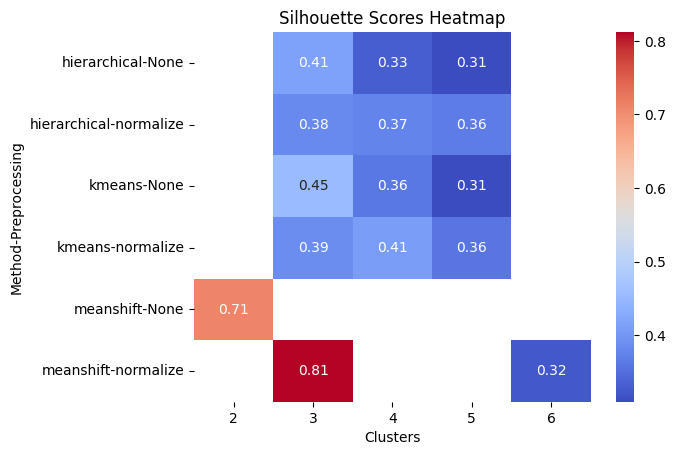

In [16]:
sns.heatmap(sil_table, annot=True, cmap='coolwarm')
plt.title('Silhouette Scores Heatmap')
plt.show()

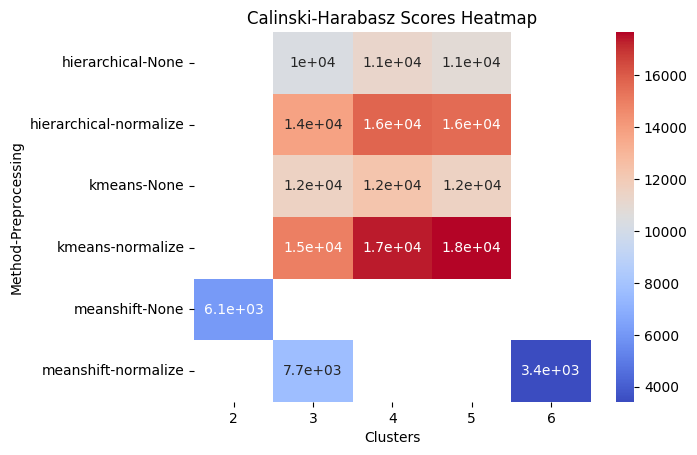

In [17]:
sns.heatmap(cal_table, annot=True, cmap='coolwarm')
plt.title('Calinski-Harabasz Scores Heatmap')
plt.show()


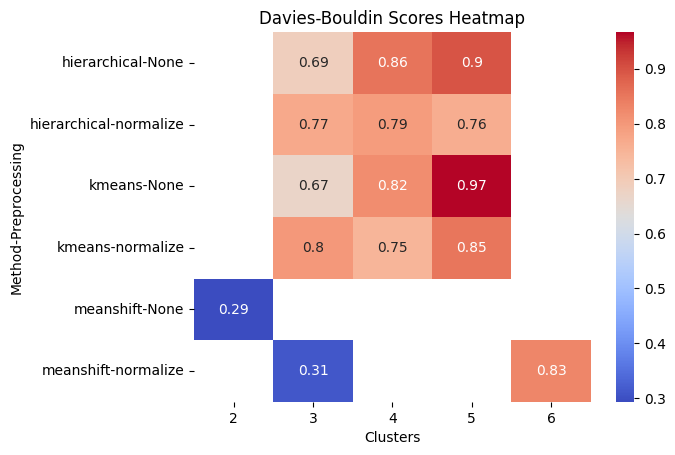

In [18]:
sns.heatmap(db_table, annot=True, cmap='coolwarm')
plt.title('Davies-Bouldin Scores Heatmap')
plt.show()


Best clustering result:
Silhouette              0.811844
Calinski-Harabasz    7676.529163
Davies-Bouldin          0.310482
Clusters                       3
Preprocessing          normalize
Method                 meanshift
Name: 27, dtype: object


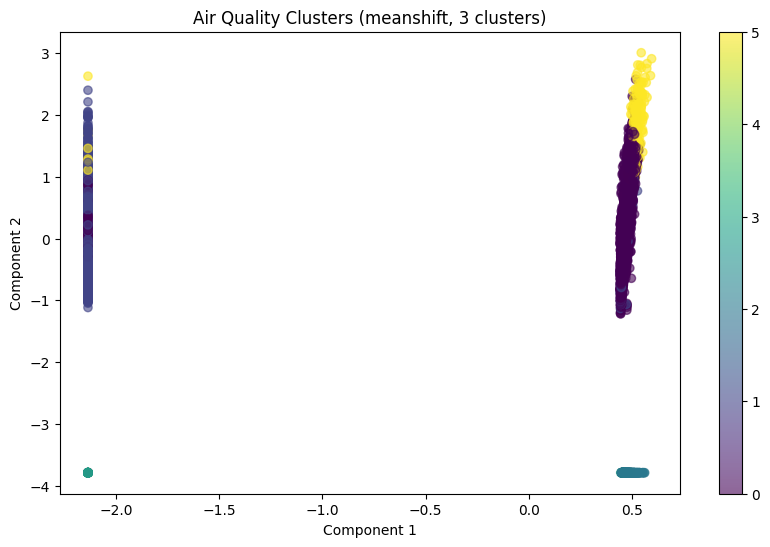

In [19]:
best_result = results_df.loc[results_df['Silhouette'].idxmax()]
print("\nBest clustering result:")
print(best_result)

# Prepare data with same preprocessing as best result
X_proc = X.copy()
if 'normalize' in best_result['Preprocessing']:
    X_proc = normalize_data(X_proc)
if 'pca' in best_result['Preprocessing']:
    X_proc = apply_pca(X_proc)

# Get labels from best result
if best_result['Method'] == 'kmeans':
    labels = run_kmeans(X_proc, best_result['Clusters'])
elif best_result['Method'] == 'hierarchical':
    labels = run_hierarchical(X_proc, best_result['Clusters'])
else:
    labels = run_meanshift(X_proc)

# Plot
if X_proc.shape[1] >= 2:
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_proc[:, 0], X_proc[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter)
    plt.title(f"Air Quality Clusters ({best_result['Method']}, {best_result['Clusters']} clusters)")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()